<a href="https://colab.research.google.com/github/xahinds2/MachineLearning/blob/main/Imdb_ratings_project_with_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

tf.keras.utils.get_file("aclImdb", url, untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 2s 0us/step


'./aclImdb'

In [3]:
import shutil
shutil.rmtree('/content/aclImdb/train/unsup')

In [4]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size = 32, validation_split = 0.2, subset='training', seed =42)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [5]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size = 32, validation_split = 0.2, subset='validation', seed =42)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size = 32)

Found 25000 files belonging to 2 classes.


In [7]:
import re
import string

def cust_std(data):
  low = tf.strings.lower(data)
  strp_html = tf.strings.regex_replace(low, '<br />', ' ')
  return tf.strings.regex_replace(strp_html, '[%s]' % re.escape(string.punctuation), '')

In [8]:
vectorize_layer = layers.TextVectorization(standardize=cust_std, max_tokens=10000, output_mode='int', output_sequence_length=250)

In [9]:
train_txt = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_txt)

In [10]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [11]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [12]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Creating Model

In [13]:
model = tf.keras.Sequential([
  layers.Embedding(10001, 16),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss = losses.BinaryCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

Training the model

In [15]:
history = model.fit(train_ds,validation_data=val_ds, epochs = 10)

Epoch 1/10
625/625 [==============================] - 11s 15ms/step - loss: 0.6631 - binary_accuracy: 0.6934 - val_loss: 0.6146 - val_binary_accuracy: 0.7732
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5499 - binary_accuracy: 0.8008 - val_loss: 0.4995 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4459 - binary_accuracy: 0.8435 - val_loss: 0.4209 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3793 - binary_accuracy: 0.8674 - val_loss: 0.3743 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3360 - binary_accuracy: 0.8794 - val_loss: 0.3454 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3057 - binary_accuracy: 0.8884 - val_loss: 0.3261 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [16]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3100 - binary_accuracy: 0.8735
Loss:  0.31002092361450195
Accuracy:  0.873520016670227


In [17]:
hist = history.history
hist.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

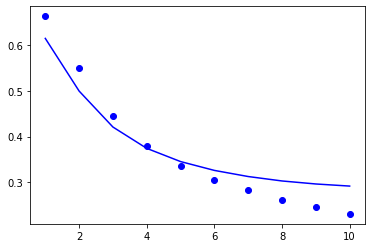

In [18]:
acc = hist['binary_accuracy']
val_acc = hist['val_binary_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

import matplotlib.pyplot as plt
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

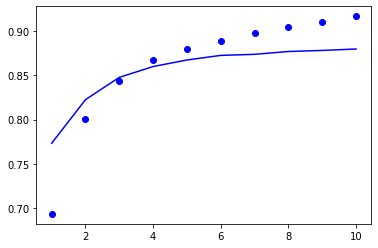

In [19]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')

In [20]:
export_model = tf.keras.Sequential([
                                 vectorize_layer,
                                 model,
                                 layers.Activation('sigmoid')
])

export_model.compile(loss = losses.BinaryCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

In [21]:
loss, acc = export_model.evaluate(raw_test_ds)
print("acc: ", acc)
print("loss: ", loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 8s 10ms/step - loss: 0.3100 - accuracy: 0.8735
acc:  0.873520016670227
loss:  0.3100210428237915


In [22]:
sahin = [
         "good great okay best"
]

In [23]:
rating = export_model.predict(sahin)
print("Rating : ", rating*10)

Rating :  [[6.9464655]]
